In [1]:
# Sort Song --> Train TweetyBERT --> HDBSCAN --> Manual Overview --> Merge / Identify Noise Clusters --> Train Classifier --> Analyze 

from scripts.npz_file_train_test_split import split_npz_into_chunks
from scripts.label_merger import read_label_file, process_labels
from src.tweety_bert.linear_probe import LinearProbeModel, LinearProbeTrainer, ModelEvaluator
from src.tweety_bert.utils import load_model
from src.tweety_bert.data_class import SongDataSet_Image, CollateFunction
from src.syllable_classifier.classify_songs import Inference 
from torch.utils.data import DataLoader
import torch
import json 
import os
import shutil

input_file = 'merge_combine.txt'  # Path to the input file
npz_file = 'files/labels_HDBSCAN_Classification.npz'  # Path to the npz file

combine, noise = read_label_file(input_file)
num_classes = process_labels(npz_file, combine, noise)

print(f"Number of classes: {num_classes}")

# load parameters.json
with open('parameters.json', 'r') as f:
    parameters = json.load(f)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load TweetyBERT model
weights_path = "/media/george-vengrovski/disk1/song_analysis_pipeline_testing_delete_when_works/temp/testingpretrain_run/5377_test_run/saved_weights/model_step_999.pth"
config_path = "/media/george-vengrovski/disk1/song_analysis_pipeline_testing_delete_when_works/temp/testingpretrain_run/5377_test_run/config.json"
tweety_bert_model = load_model(config_path, weights_path)

# split into train / test 
train_folder = "/media/george-vengrovski/disk1/song_analysis_pipeline_testing_delete_when_works/temp/linear_classifier_train"
test_folder = "/media/george-vengrovski/disk1/song_analysis_pipeline_testing_delete_when_works/temp/linear_classifier_test"
split_npz_into_chunks(npz_file, chunk_size=1000, train_folder=train_folder, test_folder=test_folder)

# Train Non-Linear Classifier
train_dataset = SongDataSet_Image(train_folder, num_classes=num_classes, decoder=True)
val_dataset = SongDataSet_Image(test_folder, num_classes=num_classes, decoder=True)
collate_fn = CollateFunction(segment_length=1000)  # Adjust the segment length if needed
train_loader = DataLoader(train_dataset, batch_size=24, shuffle=False, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=24, shuffle=False, collate_fn=collate_fn)

# Initialize and train classifier model, the num classes is a hack and needs to be fixed later on by removing one hot encodings 
classifier_model = LinearProbeModel(num_classes=num_classes, model_type="neural_net", model=tweety_bert_model,
                                    freeze_layers=True, layer_num=-2, layer_id="attention_output", classifier_dims=196)

classifier_model = classifier_model.to(device)
trainer = LinearProbeTrainer(model=classifier_model, train_loader=train_loader, test_loader=val_loader,
                                device=device, lr=1e-4, plotting=False, batches_per_eval=50, desired_total_batches=1e4, patience=4)
trainer.train()

eval_dataset = SongDataSet_Image(test_folder, num_classes=num_classes, infinite_loader=False, decoder=True)
eval_loader = DataLoader(eval_dataset, batch_size=1, shuffle=False)

# Evaluate the trained model
evaluator = ModelEvaluator(model=classifier_model, test_loader=eval_loader, num_classes=num_classes,
                            device='cuda:0', filter_unseen_classes=True, train_dir=train_folder)
                            
class_frame_error_rates, total_frame_error_rate = evaluator.validate_model_multiple_passes(num_passes=1, max_batches=1250)

# Use the name of the current cross-validation directory for the results folder
results_folder_name = os.path.basename(test_folder)

# Save the evaluation results
results_dir = os.path.join("/home/george-vengrovski/Documents/projects/song_analysis_pipeline/temp", results_folder_name)  # Modified to save into the relative path /results/{cv_dirs}
os.makedirs(results_dir, exist_ok=True)
evaluator.save_results(class_frame_error_rates, total_frame_error_rate, results_dir)

# Save Linear Decoder + Its Parameters 
save_path = os.path.join("output/decoder_classifier", "linear_decoder.pth")
os.makedirs(os.path.dirname(save_path), exist_ok=True)
torch.save(classifier_model.state_dict(), save_path)

# save a copy of the tweetybert config json and weights in the same folder 
shutil.copy(config_path, os.path.join("output/decoder_classifier", "config.json"))
shutil.copy(weights_path, os.path.join("output/decoder_classifier", "weights.pth"))

# run inference, output csv to the /output folder
# if sort songs is false, than we assume that the files that have been provided have already been sorted 




# # Use it to analyze whole dataset 
# import shutil

# # delete temp folder contents
# temp_folder_path = parameters["temp_path"]
# shutil.rmtree(temp_folder_path)
# os.makedirs(temp_folder_path, exist_ok=True) 

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24]
Number of classes: 25


Evaluating:   1%|          | 11/1250 [00:00<00:17, 72.31batch/s]


'output/decoder_classifier/weights.pth'

In [2]:
output_path = os.path.join(parameters["output_path"], "syllable_annotations_output")
model = Inference(input_path=parameters["input_path"], output_path=output_path, plot_spec_results=True, model=classifier_model, sorted_songs_path="/media/george-vengrovski/disk1/song_analysis_pipeline_testing_delete_when_works/temp/database.csv", threshold=.5, min_length=500, pad_song=50)
model.classify_all_songs()

Sorting songs:   0%|          | 0/11 [00:00<?, ?it/s]

torch.Size([1, 1, 196, 1000])
torch.Size([1, 1, 196, 1000])
torch.Size([1, 1, 196, 1000])
torch.Size([1, 1, 196, 1000])


Sorting songs:   9%|▉         | 1/11 [00:00<00:07,  1.35it/s]

torch.Size([1, 1, 196, 1000])
torch.Size([1, 1, 196, 1000])
torch.Size([1, 1, 196, 1000])
torch.Size([1, 1, 196, 1000])


Sorting songs:  18%|█▊        | 2/11 [00:01<00:06,  1.44it/s]

torch.Size([1, 1, 196, 1000])
torch.Size([1, 1, 196, 1000])
torch.Size([1, 1, 196, 1000])
torch.Size([1, 1, 196, 1000])


Sorting songs:  27%|██▋       | 3/11 [00:02<00:05,  1.44it/s]

torch.Size([1, 1, 196, 1000])
torch.Size([1, 1, 196, 1000])
torch.Size([1, 1, 196, 1000])
torch.Size([1, 1, 196, 1000])


Sorting songs:  36%|███▋      | 4/11 [00:02<00:04,  1.48it/s]

torch.Size([1, 1, 196, 1000])
torch.Size([1, 1, 196, 1000])
torch.Size([1, 1, 196, 1000])
torch.Size([1, 1, 196, 1000])


Sorting songs:  45%|████▌     | 5/11 [00:03<00:04,  1.49it/s]

torch.Size([1, 1, 196, 1000])
torch.Size([1, 1, 196, 1000])
torch.Size([1, 1, 196, 1000])
torch.Size([1, 1, 196, 1000])


Sorting songs:  55%|█████▍    | 6/11 [00:04<00:03,  1.50it/s]

torch.Size([1, 1, 196, 1000])
torch.Size([1, 1, 196, 1000])
torch.Size([1, 1, 196, 1000])
torch.Size([1, 1, 196, 1000])


Sorting songs:  64%|██████▎   | 7/11 [00:04<00:02,  1.49it/s]

torch.Size([1, 1, 196, 1000])
torch.Size([1, 1, 196, 1000])
torch.Size([1, 1, 196, 1000])
torch.Size([1, 1, 196, 1000])


Sorting songs:  73%|███████▎  | 8/11 [00:05<00:02,  1.49it/s]

torch.Size([1, 1, 196, 1000])
torch.Size([1, 1, 196, 1000])
torch.Size([1, 1, 196, 1000])
torch.Size([1, 1, 196, 1000])


Sorting songs:  82%|████████▏ | 9/11 [00:06<00:01,  1.48it/s]

torch.Size([1, 1, 196, 1000])
torch.Size([1, 1, 196, 1000])
torch.Size([1, 1, 196, 1000])
torch.Size([1, 1, 196, 1000])


Sorting songs:  91%|█████████ | 10/11 [00:06<00:00,  1.48it/s]

torch.Size([1, 1, 196, 1000])
torch.Size([1, 1, 196, 1000])
torch.Size([1, 1, 196, 1000])
torch.Size([1, 1, 196, 1000])


Processing birds: 100%|██████████| 1/1 [00:07<00:00,  7.48s/it]


Database saved to /media/george-vengrovski/disk1/song_analysis_pipeline_testing_delete_when_works/output/syllable_annotations_output/classified_songs.csv


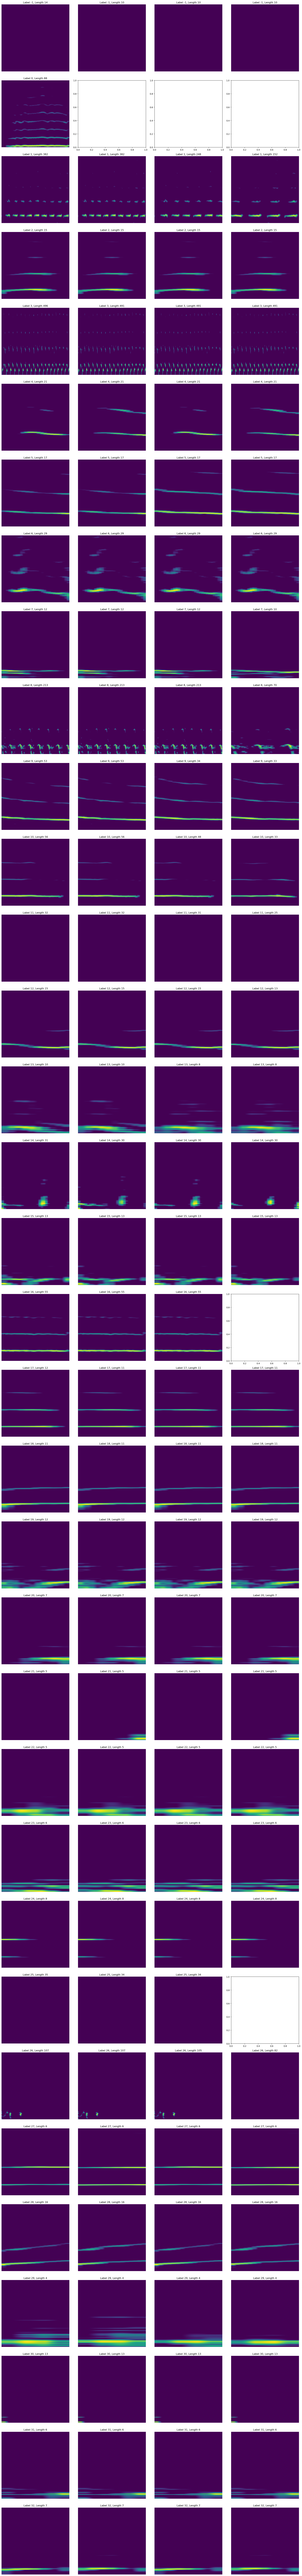

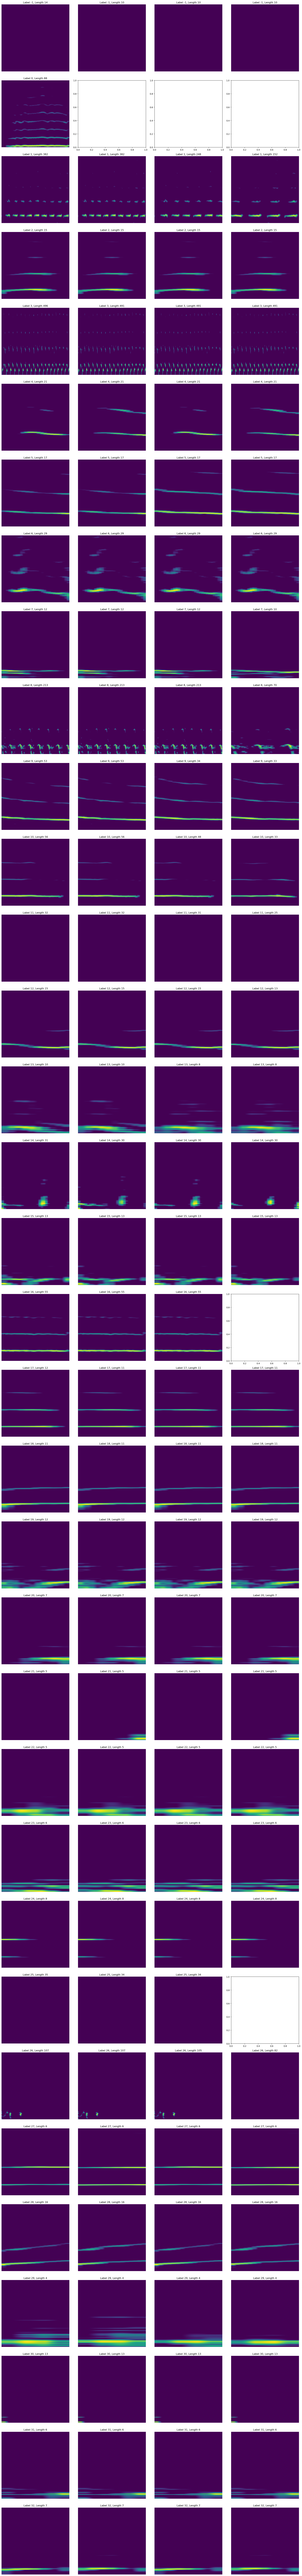

10 Examples of each cluster has been saved to /temp/joined_clusters, please inspect and merge if needed


In [2]:
from scripts.inspecting_hdbscan_labels import plot_longest_segments_by_label

# Join Clusters
# File paths
file_path = "/home/george-vengrovski/Documents/projects/song_analysis_pipeline/files/labels_HDBSCAN_Classification.npz"
output_file_path = "spectrogram_segments.png"

# Call the function
plot_longest_segments_by_label(file_path, output_file_path)
print("10 Examples of each cluster has been saved to /temp/joined_clusters, please inspect and merge if needed")
